In [3]:
import pandas as pd
import numpy as np
import os
import rasterio

In [4]:
data = pd.read_csv('../raw_data/nig_eth.csv')
data = data[data["nightlights"] < 50]
data = data[data["cons_pc"] < 30]

In [5]:
data

,country,cluster_lat,cluster_lon,cons_pc,nightlights
0,eth,3.455701,39.515994,14.854634,0.000000
1,eth,3.549937,39.184234,14.312022,0.000000
2,eth,3.864243,39.101366,12.470145,0.000000
3,eth,3.982931,38.491368,8.336539,0.000000
4,eth,4.048194,41.930928,4.762526,0.000000
...,...,...,...,...,...
1182,ng,13.202805,7.721468,1.165778,0.000777
1183,ng,13.339897,5.214480,2.710443,0.003922
1184,ng,13.555542,6.246647,1.759571,0.000000
1185,ng,13.604251,5.741676,1.647506,0.000000


In [6]:
data["cons_pc"].size

1179

In [7]:
def drop_0s(df):
    """
    Elimina el 90% de las filas donde la columna 'nightlights' es igual a 0 de forma aleatoria.

    Args:
    df (pandas.DataFrame): DataFrame de entrada que contiene una columna 'nightlights'.

    Returns:
    pandas.DataFrame: DataFrame con el 90% de las filas con 'nightlights' igual a 0 eliminadas.
    """
    # Filtrar filas donde 'nightlights' es igual a 0
    zero_nightlights = df[df['nightlights'] == 0]
    
    # Calcular el número de filas a mantener (10% de las filas con 'nightlights' igual a 0)
    n_keep = int(0.05 * len(zero_nightlights))
    
    # Seleccionar aleatoriamente el 10% de las filas para mantener
    rows_to_keep = zero_nightlights.sample(n=n_keep, random_state=42)
    
    # Filtrar filas donde 'nightlights' no es igual a 0
    non_zero_nightlights = df[df['nightlights'] != 0]
    
    # Concatenar las filas no cero con las 10% de filas cero seleccionadas para mantener
    new_df = pd.concat([non_zero_nightlights, rows_to_keep])
    
    # Opcional: Reordenar el DataFrame final
    new_df = new_df.sample(frac=1).reset_index(drop=True)
    
    return new_df

data = drop_0s(data)

In [8]:
import random
import math
RANDOM_SEED = 7

def create_space(lat, lon, s=1):
    """Creates a s km x s km square centered on (lat, lon)"""
    v = (180/math.pi)*(500/6378137)*s 
    return lat - v, lon - v, lat + v, lon + v

def generate_download_locations(df, ipc=4):
    '''
    Takes a dataframe with columns cluster_lat, cluster_lon
    Generates a 10km x 10km bounding box around the cluster and samples 
    ipc images per cluster. First samples in a grid fashion, then any 
    remaining points are randomly (uniformly) chosen
    '''
    np.random.seed(RANDOM_SEED) # for reproducability
    df_download = {'image_name': [], 'image_lat': [], 'image_lon': [], 'cluster_lat': [], 
                   'cluster_lon': [], 'cons_pc': [], 'nightlights': [], 'country': []}
    
    # side length of square for uniform distribution
    edge_num = math.floor(math.sqrt(ipc))
    for _, r in df.iterrows():
        min_lat, min_lon, max_lat, max_lon = create_space(r.cluster_lat, r.cluster_lon)
        lats = np.linspace(min_lat, max_lat, edge_num).tolist()
        lons = np.linspace(min_lon, max_lon, edge_num).tolist()

        # performs cartesian product
        uniform_points = np.transpose([np.tile(lats, len(lons)), np.repeat(lons, len(lats))])
        
        lats = uniform_points[:,0].tolist()
        lons = uniform_points[:,1].tolist()
        
        # fills the remainder with random points
        for _ in range(ipc - edge_num * edge_num):
            lat = random.uniform(min_lat, max_lat)
            lon = random.uniform(min_lon, max_lon)
            lats.append(lat)
            lons.append(lon)
        
        # add to dict
        for lat, lon in zip(lats, lons):
            # image name is going to be image_lat_image_lon_cluster_lat_cluster_lon.png
            image_name = str(lat) + '_' + str(lon) + '_' + str(r.cluster_lat) + '_' + str(r.cluster_lon) + '.png'
            df_download['country'].append(r.country)
            df_download['image_name'].append(image_name)
            df_download['image_lat'].append(lat)
            df_download['image_lon'].append(lon)
            df_download['cluster_lat'].append(r.cluster_lat)
            df_download['cluster_lon'].append(r.cluster_lon)
            df_download['cons_pc'].append(r.cons_pc)
            df_download['nightlights'].append(r.nightlights)
        
    return pd.DataFrame.from_dict(df_download)

new_data = generate_download_locations(data)

<AxesSubplot:xlabel='nightlights', ylabel='cons_pc'>

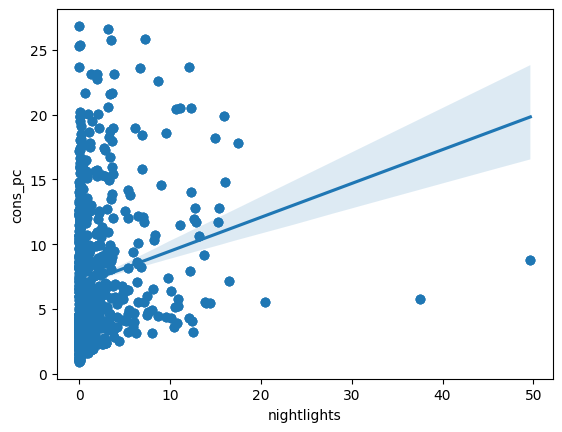

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
# cerate a scatter reg with new_data['cons_pc'], new_data['nightlights']
sns.regplot(x='nightlights', y='cons_pc', data=new_data)

In [10]:
data_test = pd.read_csv('../raw_data/nig_eth.csv')
data_test.drop_duplicates()
data_test = drop_0s(data_test)
data_test = data_test[data_test["nightlights"] < 40]
data_test = data_test[data_test["cons_pc"] < 40]

In [11]:
# create a linear regression model with new_data['cons_pc'], new_data['nightlights']
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = data_test['nightlights'].values.reshape(-1, 1)
y = data_test['cons_pc'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# try with a kn neighbors model
from sklearn.neighbors import KNeighborsRegressor

model_k = KNeighborsRegressor(n_neighbors=5)
model_k.fit(X_train, y_train)


KNeighborsRegressor()

In [13]:
# create a SVM model
from sklearn import svm
model_svm = svm.SVR()
model_svm.fit(X_train, y_train)

SVR()

In [16]:
y_pred_svm = model_svm.predict(X_test)
score_r_2 = r2_score(y_test, y_pred_svm)
score_r_2

-0.0511248546515326

In [184]:
grid_search.best_params_

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

In [18]:

model_k = KNeighborsRegressor(n_neighbors=11, weights='uniform', metric='euclidean')
model_k.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=11)

In [19]:
new_y_k = model_k.predict(X_test)

In [22]:
new_r2_score = r2_score(y_test, new_y_k)
new_r2_score

0.08786597945915153

In [23]:
y_pred = model.predict(X_test)

In [24]:
y_pred_k = model_k.predict(X_test)

In [25]:
square_error = r2_score(y_test, y_pred)
square_error

0.05820360806391278

In [26]:
square_error_k = r2_score(y_test, y_pred_k)
square_error_k

0.08786597945915153

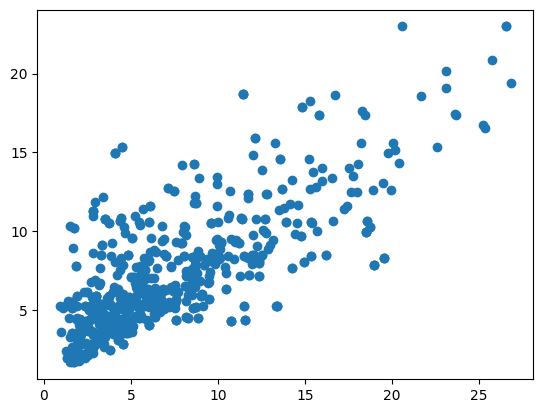

In [127]:
# plot y_pred_k againts y_test
plt.scatter(y_test, y_pred_k)

In [97]:
# create csv
new_data.to_csv('../raw_data/download_locations.csv', index=False)

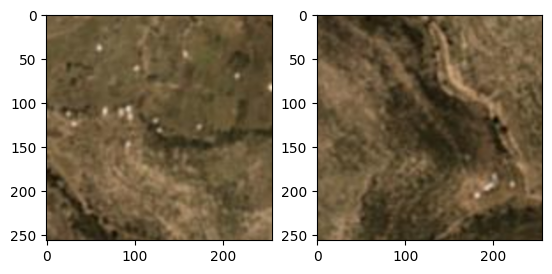

In [94]:
from ll_utils import PlanetDownloader
import matplotlib.pyplot as plt
client = PlanetDownloader()
# reload import
%reload_ext autoreload
plt.subplot(1, 2, 1)
img = client.download_image(9.378552,41.592951, 2015, 1,2016,12)
plt.imshow(img)
plt.subplot(1, 2, 2)


img2 = client.download_image(9.369569,41.592951	, 2015, 1,2016,12)
plt.imshow(img2)


In [74]:
# import folium
# m = folium.Map(location=[new_data['image_lat'].mean(), new_data['image_lon'].mean()], zoom_start=15)

# for idx, row in new_data.iterrows():
#     folium.CircleMarker(
#         location=[row['image_lat'], row['image_lon']],
#         radius=5,
#         color='blue',
#         fill=True,
#         fill_color='blue',
#         fill_opacity=0.7,
#         popup=row['image_name']
#     ).add_to(m)
    
# points_mapped = []
# for idx, row in new_data.iterrows():
#     if [row['cluster_lat'], row['cluster_lon']] not in points_mapped:
#         folium.CircleMarker(
#             location=[row['cluster_lat'], row['cluster_lon']],
#             radius=7,
#             color='red',
#             fill=True,
#             fill_color='red',
#             fill_opacity=0.7,
#             popup='Cluster Point'
#         ).add_to(m)
#         points_mapped.append([row['cluster_lat'], row['cluster_lon']])
        
# # Mostrar el mapa
# m.save('index_4.html')

In [ ]:
def load_model():
    # Cargar VGG16 como base del modelo para las imágenes
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = True
    
    # Entrada para las imágenes
    image_input = Input(shape=(224, 224, 3))
    x = base_model(image_input)
    x = Flatten()(x)

    # Entrada para la variable nightlights
    nightlight_input = Input(shape=(1,))
    
    # Combinar las salidas de las dos redes
    combined = Concatenate()([x, nightlight_input])

    # Capas densas después de la concatenación
    x = Dense(200, activation='relu')(combined)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(50, activation='relu')(x)
    output = Dense(1, activation='linear')(x)

    # Crear modelo
    model = Model(inputs=[image_input, nightlight_input], outputs=output)
    model.compile(optimizer='adam', loss='mae')

    return model